# __SARIMA(p,d,q)(P,D,Q)m__
# __Seasonal Autoregressive Integrated Moving Averages__
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next notebook.

In [15]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

import matplotlib.pyplot as plt

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv('../data/co2_mm_mlo.csv')

### __Inspect the data, create a DatetimeIndex__

In [18]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [19]:
# Add a "date" datetime column
df['date']=pd.to_datetime({'year':df['year'], 'month':df['month'], 'day':1})

In [20]:
# Set "date" to be the index
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Freq: MS
Data columns (total 5 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
dtypes: float64(3), int64(2)
memory usage: 34.2 KB


### __Plot data__

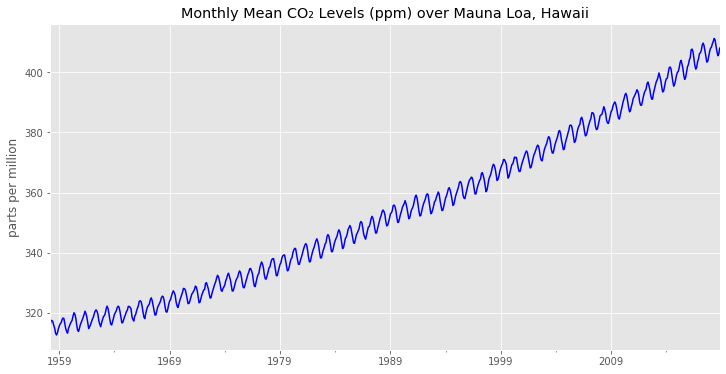

In [22]:
plt.style.use('ggplot')

title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' # we don't really need a label here

ax = df['interpolated'].plot(figsize=(12,6),title=title, color='blue')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### __Seasonal decompose__

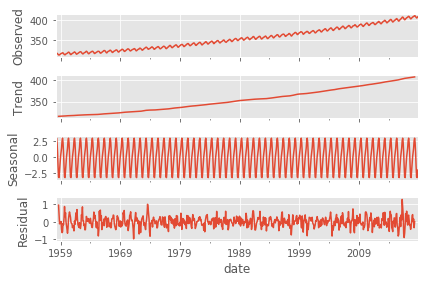

In [23]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Seasonality exists

### __Run pmdarima.auto_arima to get recommended orders__
Prepare to wait for a while

In [14]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -208.275
Date:                            Tue, 19 Nov 2019   AIC                            428.550
Time:                                    14:57:26   BIC                            456.091
Sample:                                         0   HQIC                           439.177
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      1.009      0.313      -0.000       0.000
ma.L1         -0.3562      0.037     -9.719      0.000      -0.428      -0.284
ma.L2         -0.0615      0.033     -1.844      0.065      -0.127       0.004
ar.S.L12       0.9996      0.000   3048.169      0.000       0.999       1.000
ma.S.L12      -0.8654      0.022    -40.083      0.000      -0.908      -0.823
sigma2         0.0963      0.005     20.314      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       50.10   Jarque-Bera (JB):                 4.37
Prob(Q):                              0.13   Prob(JB):                         0.11
Heteroskedasticity (H):               1.11   Skew:                            -0.02
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12). Next step is to train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### __train / test split__

In [41]:
len(df)

729

In [42]:
# Set one year for testing
train = df.iloc[:717]
test = df.iloc[717:]

### __Fit SARIMA(0,1,3)(1,0,1,12) model__

In [43]:
model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -201.190
Date:                            Tue, 19 Nov 2019   AIC                            414.379
Time:                                    15:51:45   BIC                            441.821
Sample:                                03-01-1958   HQIC                           424.976
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3541      0.036     -9.824      0.000      -0.425      -0.283
ma.L2         -0.0248      0.035     -0.700      0.484      -0.094       0.045
ma.L3         -0.0869      0.033     -2.606      0.009      -0.152      -0.022
ar.S.L12       0.9997      0.000   3058.958      0.000       0.999       1.000
ma.S.L12      -0.8668      0.023    -38.504      0.000      -0.911      -0.823
sigma2         0.0950      0.005     20.302      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.95   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

In [29]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['interpolated'][i]}")

predicted=406.6098861, expected=406.81
predicted=407.8248514, expected=407.96
predicted=408.5788433, expected=408.32
predicted=409.4838247, expected=409.41
predicted=411.0393447, expected=410.24
predicted=411.642275 , expected=411.24
predicted=410.8630395, expected=410.79
predicted=409.1735271, expected=408.71
predicted=407.0731977, expected=406.99
predicted=405.6227532, expected=405.51
predicted=405.892521 , expected=406.0
predicted=407.4256078, expected=408.02


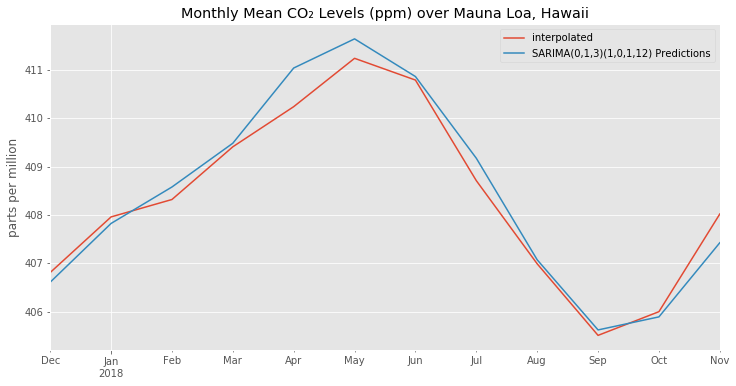

In [31]:
# Plot predictions vs actuals

plt.style.use('ggplot')

title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### __Model evaluation__

In [32]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.128018237


In [37]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3577963625


In [38]:
error = error / test.interpolated.mean()
error

0.000876235989764244

### __Apply model to full dataset to forecast__

In [39]:
model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

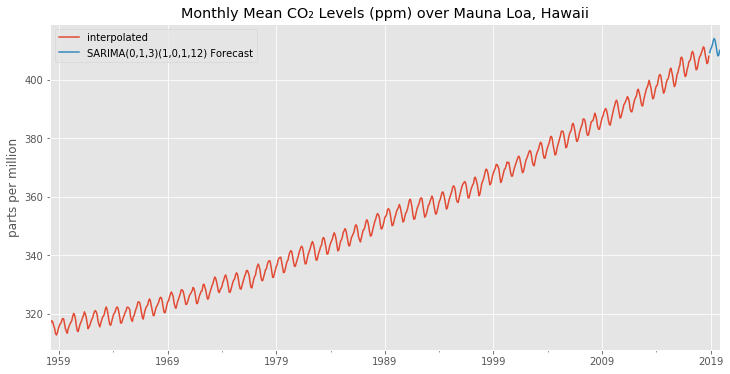

In [40]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);